<h2>Before you start</h2>
If this is the first time the pipeline is running on this machine, just run the cell below. It will copy startup.py from the BEARMIND folder into your local startup folder. This allows the code in startup.py to be executed automatically after each kernel restart (and removes the need to monotonously click through all setup cells after each reloading).

In [4]:
import shutil
import os

local_startup_dir = get_ipython().profile_dir.startup_dir
filedir = os.getcwd()
shutil.copy(os.path.join(filedir, 'startup.py'), os.path.join(local_startup_dir, 'startup.py'))

'C:\\Users\\admin\\.ipython\\profile_default\\startup\\startup.py'

<h2>Module 0</h2>
You need to specify the root folder and pathway pattern. Note that * is a wildcard for any symbol combination except slashes (i.e., for any folder name), so it is strongly recommended to use it here.<br/><br/>
NB!! Just in case, use double backslashes for folder separation, otherwise some symbols may be interpreted as escape sequences. 

In [5]:
config_data = {
    'ROOT': 'c:\\Users\\admin\\Projects\\H_mice\\Estimates_NOF\\',
    'DATA_PATHWAY': 'bonsai'
}

update_config(config_data)

In [1]:
CONFIG

{'ROOT': 'C:\\Users\\admin\\Projects\\H_mice\\Estimates_NOF',
 'DATA_PATHWAY': 'bonsai',
 'CPUs': 28,
 'RAM': 64}

In [ ]:
create_mouse_configs(root=CONFIG['ROOT'])

<h2>Module 1</h2>
Manual video inspection. <br/>Open folder with miniscopic videos in a pop-up window, wait for loading and specify margins to be cropped by sliders or by keyboard, then save them by running the next cell. At the time, cropping .pickle files are to be created in these folders. Repeat for all folders with miniscopic videos you would like to analyze.   

In [ ]:
#Manual file selection:
fnames = list(askopenfilenames(title = 'Select files for inspection', initialdir = CONFIG['ROOT'], filetypes = [('AVI files', '.avi')]))
#OR, alternatively, you can use Automatic file selection
#fnames = glob(CONFIG['ROOT'] + folder_structure + '*.avi')

data = LoadSelectedVideos(fnames)
w = DrawCropper(data, fname=fnames[0])

Batch cropping and timestamp extraction.<br/>Miniscopic videos from folders with .pickle files are to be cropped and saved as _CR.tif in the root folder. There is no need for renaming of sigle-digit .avi files (like 0-9.avi to 00-09.avi)!<br/>
Also, along with video data, timestamps are to be copied from minicopic folders to the root folder. Do not delete them, they are nessesary for the further steps!

In [ ]:
#Batch crop
cpath_template = os.path.normpath(os.path.join(CONFIG['ROOT'], folder_structure, '*cropping.pickle'))
pick_names = glob(cpath_template)

print([get_session_name_from_path(fname) for fname in pick_names])
# TODO: read from mouse config only!
'''
for name in pick_names:
    DoCropAndRewrite(name)
    extract_and_copy_ts(name)
'''

<h2>Module 2</h2>
Batch motion correction.<br/>All _CR.tif files in the root folder are to be automatically motion corrected with NoRMCorre routine [Pnevmatikakis, Giovanucci, 2017] with the parameters below and saved as _MC.tif files.

In [ ]:
#Automatic file selection
fnames = glob(os.path.join(CONFIG['ROOT'], '*_CR.tif'))
#OR, alternatively, you can use manual file selection:
#fnames = askopenfilenames(title = 'Select files for motion correction', initialdir = CONFIG['ROOT'], filetypes = [('TIFF files', '.tif')])

mc_dict = {
    'pw_rigid': False,         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
    'max_shifts': (35, 35),    # maximum allowed rigid shift
    'gSig_filt': (8, 8),       # size of high pass spatial filtering, used in 1p data
    'strides': (48, 48),       # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (24, 24),      # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 15,  # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy',      # replicate values along the boundaries
    'use_cuda': True,          # Set to True in order to use GPU
    'memory_fact': CONFIG['RAM']/16.0,          # How much memory to allocate. 1 works for 16Gb, so 0.8 showd be optimized for 12Gb.
    'niter_rig': 1,
    'splits_rig': 20,          # for parallelization split the movies in  num_splits chuncks across time
                               # if none all the splits are processed and the movie is saved
    'num_splits_to_process_rig': None} # intervals at which patches are laid out for motion correction  

for name in tqdm.tqdm(fnames):
    DoMotionCorrection(name, mc_dict)
    CleanMemmaps(name)

In [ ]:
ms_name = 'H02'
mc_to_config = {'mc_params': mc_dict}

ms_config_path = get_mouse_config_path(ms_name)
update_config(mc_to_config, name=ms_config_path)

<h3>Module 2.5 (optional)</h3>
Pre-test of various values of <i>gSig</i> parameter, which is used in the Module 3 and corresponds to a typical radius of a neuron in pixels.<br/>You can play with this parameter but you can use the default value of gSig = 6 as well. <br/> Calculation may take a while, so be patient!

In [2]:
cnmf_dict= {'fr': 20,                   # frame rate, frames per second (NOW RECALCULATED FOR EACH FILE FROM TIMESTAMP DATA)
            'decay_time': 1,            # typical duration of calcium transient 
            'method_init': 'corr_pnr',  # use this for 1 photon
            'K': None,                  # upper bound on number of components per patch, in general None
            'gSig': (6, 6),             # gaussian HALF-width of a 2D gaussian kernel (in pixels), which approximates a neuron
            'gSiz': (25, 25),           # maximal radius of a neuron in pixels
            'merge_thr': 0.8,          # merging threshold, max correlation allowed
            'p': 1,                     # order of the autoregressive system
            'tsub': 1,                  # downsampling factor in time for initialization
            'ssub': 1,                  # downsampling factor in space for initialization
            'rf': 40,                   # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
            'stride': 25,               # amount of overlap between the patches in pixels(keep it at least large as gSiz, i.e 4 times the neuron size gSig) 
            'only_init': True,          # set it to True to run CNMF-E
            'nb': 0,                    # number of background components (rank) if positive, else exact ring model with following settings: nb= 0: Return background as b and W, gnb=-1: Return full rank background B, gnb<-1: Don't return background
            'nb_patch': 0,              # number of background components (rank) per patch if nb>0, else it is set automatically
            'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
            'low_rank_background': None,           # None leaves background of each patch intact, True performs global low-rank approximation if gnb>0
            'update_background_components': True,  # sometimes setting to False improve the results
            'min_corr': .8,                        # min peak value from correlation image
            'min_pnr': 10,                         # min peak to noise ratio from PNR image
            'normalize_init': False,               # just leave as is
            'center_psf': True,                    # leave as is for 1 photon
            'ssub_B': 2,                           # additional downsampling factor in space for background
            'ring_size_factor': 1.5,               # radius of ring is gSiz*ring_size_factor
            'del_duplicates': True,                # whether to remove duplicates from initialization
            'border_pix': 5,                       # number of pixels to not consider in the borders
            'min_SNR': 3,                          # adaptive way to set threshold on the transient size
            'rval_thr': 0.95,                      # threshold on space consistency           
            'use_cnn': False}                      # whether to use CNNs for event detection  

Code snippet for manual calculation of imax for corrupted images

In [22]:
fname = askopenfilename(title = 'Select estimates file for examination',
                        initialdir = CONFIG['ROOT'],
                        filetypes = [('estimates files', '*estimates.pickle')])

print('estimates:', fname)
estimates = LoadEstimates(fname, default_fps=20)

# вот здесь надо руками вписать нужный тифф-файл, автоматизировать не нужно, т.к. структура папок везде разная
tifpath = "C:\\Users\\admin\\Projects\\H_mice\\HM_NOF_2D\\NOF_H04_4D_CR_MC.tif"

gsig=6
avim = build_average_image(tifpath, gsig)
estimates.imax = avim
out_name = fname.partition('_estimates')[0] + '_manual_imax_estimates.pickle'
print('edited estimates:', out_name)
with open(out_name, "wb") as f:
    pickle.dump(estimates, f)

estimates: C:/Users/admin/Projects/H_mice/Estimates_NOF/NOF_H04_4D_CR_MC_sf=--_ef=--_estimates.pickle
edited estimates: C:/Users/admin/Projects/H_mice/Estimates_NOF/NOF_H04_4D_CR_MC_sf=--_ef=--_manual_imax_estimates.pickle


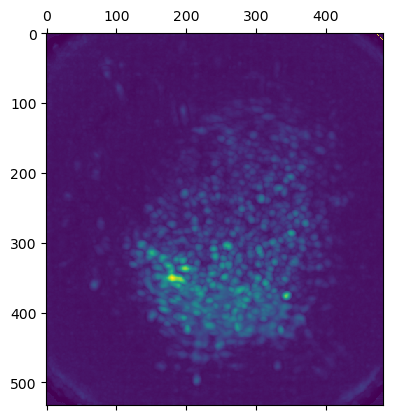

In [23]:
plt.matshow(avim)

In [ ]:
fnames = glob(os.path.join(CONFIG['ROOT'], '*_MC.tif'))
#OR, alternatively, you can use manual file selection:
#fnames = askopenfilenames(title = 'Select files for gSig testing', initialdir = config.ROOT, filetypes = [('TIFF files', '.tif')])

#Test_gSig_Range(fnames[0])
Test_gSig_Range(fnames[0], maxframes = 1000)  # maxframes is the amount of frames taken into account, by default the whole file is to be taken, which may be too slow for large files

In [ ]:
ms_name = 'H02'
cnmf_to_config = {'cnmf_params': cnmf_dict}

ms_config_path = get_mouse_config_path(ms_name)
update_config(cnmf_to_config, name=ms_config_path)

<h2>Module 3</h2>
Batch cnmf.<br/>All _MC.tif files in the root folder are to be automatically processed with CaImAn routine [Giovanucci et al., 2019] with the parameters below. Main parameters are gSig and gSiz for cell augmentation, then min_SNR as traces quality threshold. At the end, _estimates.pickle files are to be produced in the root folder. 

In [ ]:
# fnames = glob(os.path.join(CONFIG['ROOT'], '*_MC.tif'))
#OR, alternatively, you can use manual file selection:
fnames = askopenfilenames(title = 'Select files for batch cnmf', initialdir = CONFIG['ROOT'], filetypes = [('TIFF files', '.tif')])

#start_frame = 0
#end_frame = 3000

#for gsig in [6,7,8]:
#    cnmf_dict.update({'gSig': (gsig, gsig)})
    
for name in tqdm.tqdm(fnames):
    fps = get_fps_from_timestamps(name[:-4-6], default_fps=20, verbose=False)
    cnmf_dict.update({'fr': fps})
    #out_name = name[:-4] + f'_gsig={gsig}'
    out_name = name[:-4]
    
    DoCNMF(name,
           cnmf_dict,
           out_name=out_name,
           #start_frame=start_frame,
           #end_frame=end_frame,
           verbose=True)
    
    CleanMemmaps(name)

<h2>Module 4</h2>
User inspection of cnmf results.<br/>
Btw, at this stage, previously saved timestamps are to be merged with cnmf results.
By running the section below, you will be prompted to select estimtes file with cnmf results and then to interactively examine detected units (you can select both spatial and temporal components), you can select, merge and delete them, also you can seed new neurons (by PointDrawTool) for further re-run of CNMF with saved seeds. Finally, you can save (by pressing 'Save Results') spatial and temporal components as .tif and traces.csv files, respectively. Spatial components (aka filters) are to be stored in a separate folder (*_filters).

In [2]:
import time
fname = askopenfilename(title = 'Select estimates file for examination',
                        initialdir = CONFIG['ROOT'],
                        filetypes = [('estimates files', '*estimates.pickle')])

bkapp_kwargs = {
    'fill_alpha': 0.45,       # selected neuron transparency
    'ns_alpha': 0.2,         # non-selected neuron transparency
    'line_width': 0.5,         # border width
    'cthr': 0.35,             # coutour_thr from caiman (% of signal inside a patch), affects patch size
    'line_alpha': 0.5,           # border transparency
    'trace_line_width': 1,       # trace line width
    'trace_alpha': 0.7,          # trace transparency
    'size': 500,
    'button_width': 110,         # button width in pixels
    'verbose': 0,
    'enable_gpu_backend': 1
}

ExamineCells(fname, default_fps=20, bkapp_kwargs=bkapp_kwargs)

In [ ]:
fnames = askopenfilenames(title = 'Select files for batch cnmf',
                          initialdir = CONFIG['ROOT'],
                          filetypes = [('TIFF files', '.tif')])

#fnames = glob(os.path.join(CONFIG['ROOT'], '*_MC.tif'))

ManualSeeds(fnames[0], size=800, cnmf_dict=None)

Redo cnmf with manually added seeds (optional).<br/>
NB!! By running the cell below, you will rewrite existing estimates files!!<br/>
Then you can return to the section above and inspect the rewritten estimates.

In [ ]:
s_names = glob(os.path.join(CONFIG['ROOT'], '*seeds.pickle'))
#OR, alternatively, you can use manual file selection:
#s_names = askopenfilenames(title = 'Select seeds files for re-CNMFing', initialdir = CONFIG['ROOT'], filetypes = [('seeds files', '*seeds.pickle')])


for s_name in s_names:
    base_name = s_name.partition('_seeds')[0][:-4]
    
    e_names = glob(base_name + '_estimates.pickle')
    tif_names = glob(base_name + '.tif')
    ReDoCNMF(s_name, e_name=None, tif_name=tif_names[0], cnmf_dict=cnmf_dict)
    CleanMemmaps(base_name)

<h2>Module 5</h2>
Batch event detection. <br/>
INPUT: (timestamped) cnmf raw traces as *_traces.csv files<br/>
OUTPUT: detected events as *_spikes.csv files; pickles with events (cell-wise list of event-wise lists with dictionaries) and also, interactive .html plot with traces and events.

In [ ]:
fnames = glob(CONFIG['ROOT'] + '*traces.csv')
#OR, alternatively, you can use manual file selection:
#fnames = askopenfilenames(title = 'Select traces for event detection', initialdir = CONFIG['ROOT'], filetypes = [('traces files', '*traces.csv')])

sd_dict = {'thr': 4,        #threshold for peaks in Median Absolute Deviations (MADs)                   
           'sigma' : 7,     #smoothing parameter for peak detection, frames
           'est_ton' : 0.5, #estimated event rising time, s
           'est_toff' : 2,  #estimated event decay time, s
           'draw_details': True} #whether to draw smoothed traces, peaks, pits and fits 

for name in fnames:
    FitEvents(name, opts = sd_dict)


Also, just in case, you may draw existed pairs of traces and spikes right here:

In [ ]:
fnames = glob(CONFIG['ROOT'] + '*traces.csv')
for name in fnames:
    DrawSpEvents(name, name.replace('traces','spikes'))
